# SIR Model in SD DSL

![Image](images/sir_model.png)

## Model

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=1.0,stoptime=1500.0,dt=1.0,name='Sir_model')

## Stocks

In [2]:
susceptible = model.stock("S")
infectious = model.stock("I")
recovered = model.stock("R")
deaths = model.stock("D")

In [3]:
susceptible.initial_value = 80000000.0
infectious.initial_value = 120.0
recovered.initial_value = 0.0
deaths.initial_value = 0.0

## Flows

In [4]:
infection_rate = model.flow("IR")
recovery_rate = model.flow("RR")
death_rate = model.flow("DR")

## Converters

In [5]:
contact_rate = model.converter("c")
total_population = model.converter("TP")
net_population = model.converter("N")
intensive_needed = model.converter("needed")
intensive_rate = model.constant("irate")
infectivity = model.constant("i")
intensive_available = model.constant("available")
lethality = model.constant("L")
average_duration = model.constant("d")

## Equations

In [6]:
susceptible.equation = -infection_rate
infectious.equation = infection_rate - recovery_rate - death_rate
recovered.equation = recovery_rate
deaths.equation = death_rate

In [7]:
infectivity.equation = 0.02
intensive_rate.equation = 0.002
intensive_available.equation = 30000.0
lethality.equation = 0.001
average_duration.equation = 20.0

In [8]:
contact_rate.equation = 20.0 
total_population.equation = susceptible+infectious+recovered
net_population.equation = total_population-deaths
intensive_needed.equation =infectious*intensive_rate

In [9]:
infection_rate.equation = (contact_rate*susceptible*infectivity)*(infectious/total_population)
recovery_rate.equation = infectious/average_duration
death_rate.equation = infectious*lethality

## Register model

In [10]:
import BPTK_Py
import pandas as pd
bptk = BPTK_Py.bptk()
bptk.register_model(model)

In [11]:
bptk.register_scenarios(
    scenarios ={
        "contactLargeGroups": {},
        "contactSmallGroups": {},
        "contactTwoPeople": {}
    },
    scenario_manager="smSir_model")

## Scenarios

### Base

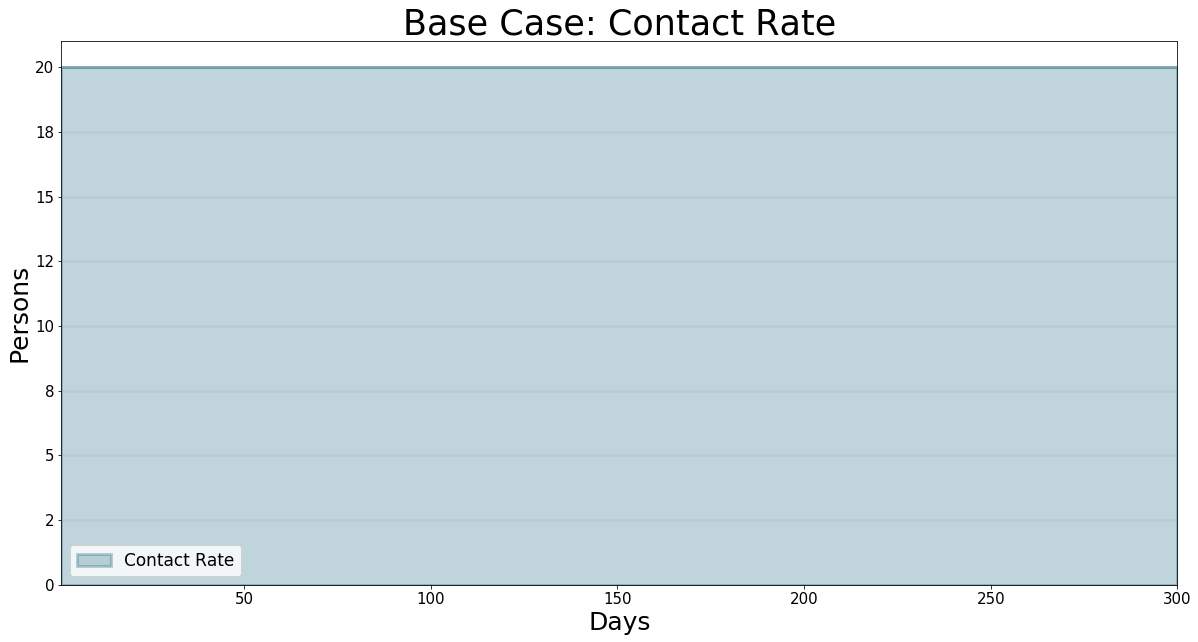

In [12]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["base"],
    title="Base Case: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["c"],
    visualize_to_period=300,
    series_names={
        "smSir_model_base_c" : "Contact Rate"
    }
)

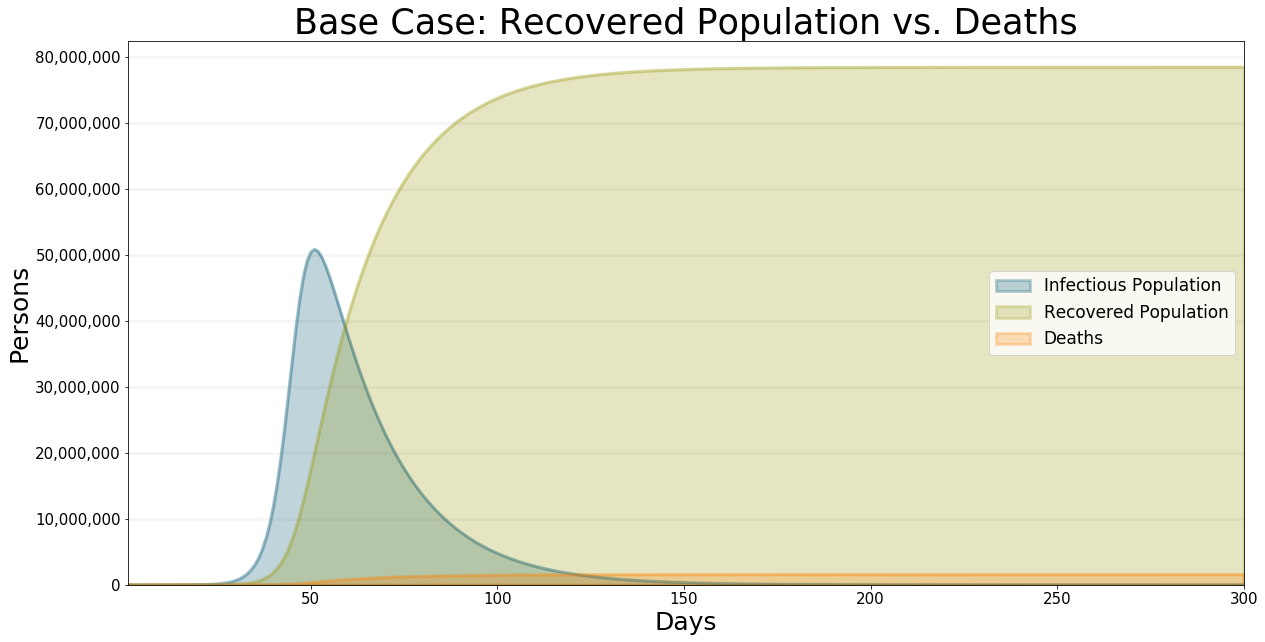

In [13]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    visualize_to_period=300,
    series_names={
        "smSir_model_base_I" : "Infectious Population",
        "smSir_model_base_R" : "Recovered Population",
        "smSir_model_base_D": "Deaths"
    }
)

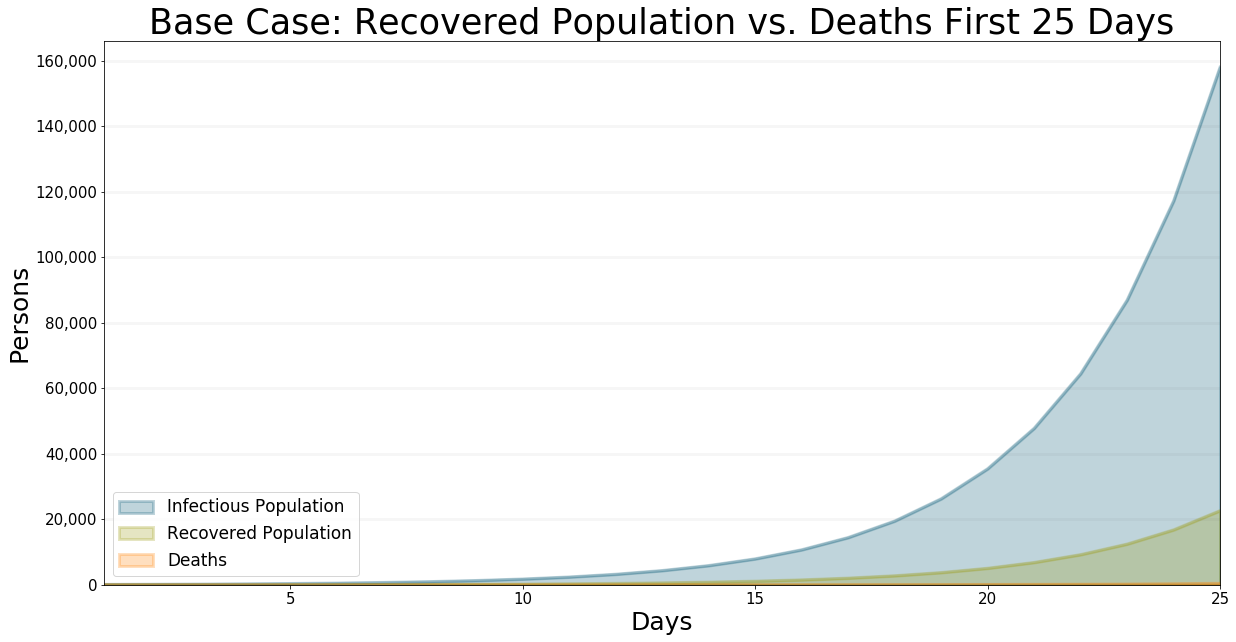

In [14]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths First 25 Days",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_model_base_I" : "Infectious Population",
        "smSir_model_base_R" : "Recovered Population",
        "smSir_model_base_D": "Deaths"
    },
    visualize_from_period=0,
    visualize_to_period=25
)

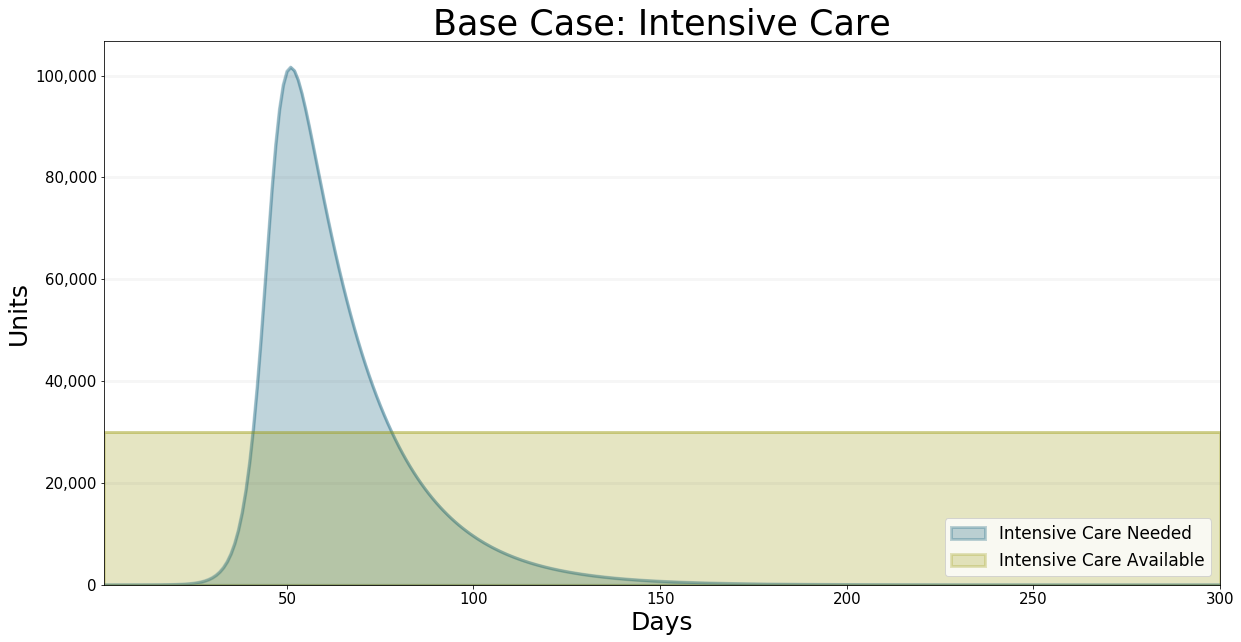

In [16]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["base"],
    title="Base Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_model_base_needed" : "Intensive Care Needed",
        "smSir_model_base_available" : "Intensive Care Available"  
    },
    visualize_to_period=300
)

### Reducing Contact Rate Slowly

In [21]:
from BPTK_Py.sdcompiler.sdmodel import LERP
contact_rate = int(bptk.scenario_manager_factory.scenario_managers['smSir_model'].scenarios['base'].model.equations['c'](0))

In [22]:
model_large_groups = bptk.scenario_manager_factory.scenario_managers['smSir_model'].scenarios['contactLargeGroups'].model
stoptime_large_groups = int(model_large_groups.stoptime)

points_list_large = []
contact_large = contact_rate
for t in range(stoptime_large_groups):
    if t%40==0 and t!=0 and t < 365:
        contact_large = contact_large - 2
    if t == 600:
        contact_large = 6
    if t == 700:
        contact_large = 10
    if t == 800:
        contact_large = 14
    if t == 900:
        contact_large = 20
    points_list_large.append((t,contact_large))


model_large_groups.points["contactPointsLarge"] = points_list_large
model_large_groups.equations["c"] = lambda t: LERP(t,model_large_groups.points["contactPointsLarge"])

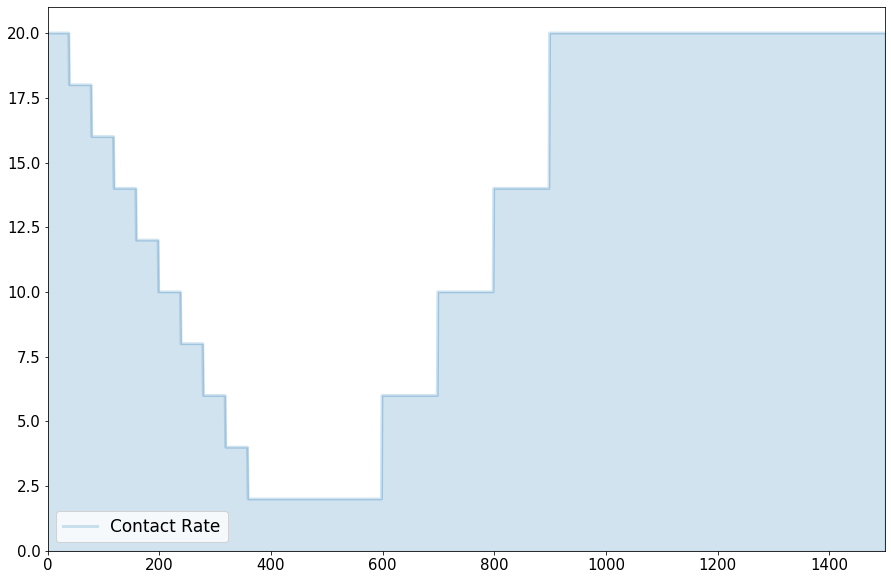

In [23]:
ax = pd.DataFrame([model_large_groups.equations["c"](t) for t in range(int(model_large_groups.starttime),int(model_large_groups.stoptime+1))]).plot(kind="area",alpha=0.2,figsize=(15,10))
ax.legend(["Contact Rate"])

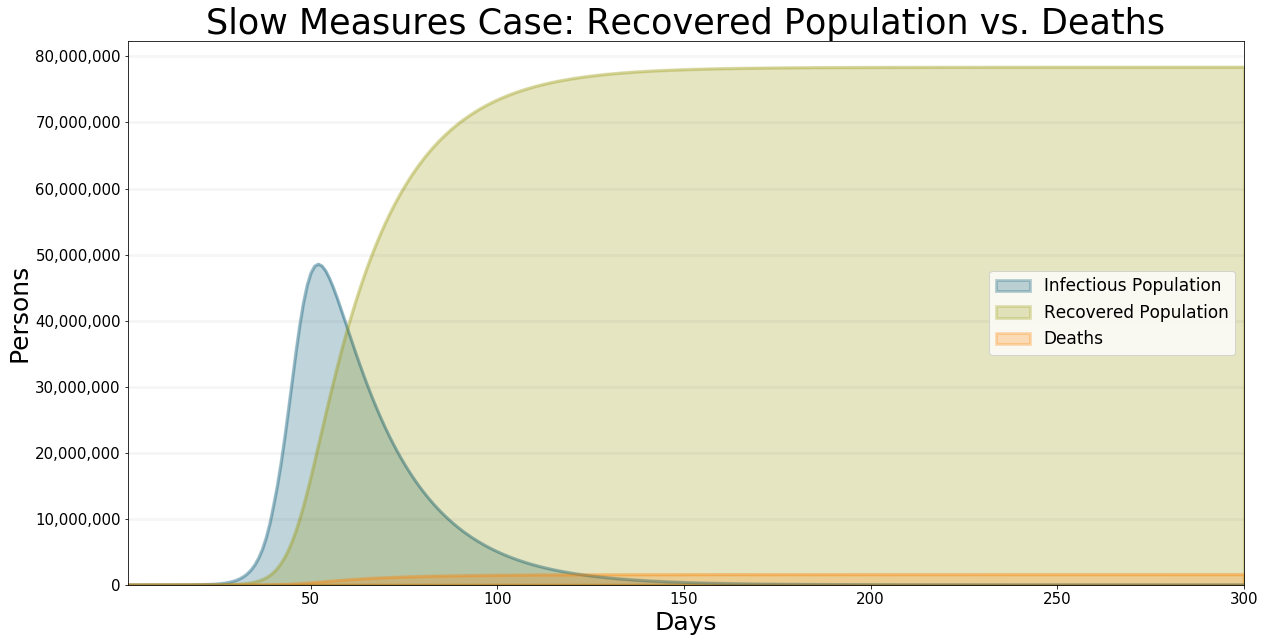

In [24]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactLargeGroups"],
    title="Slow Measures Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_model_contactLargeGroups_I" : "Infectious Population",
        "smSir_model_contactLargeGroups_R" : "Recovered Population",
        "smSir_model_contactLargeGroups_D": "Deaths"
    },
    visualize_to_period=300
)

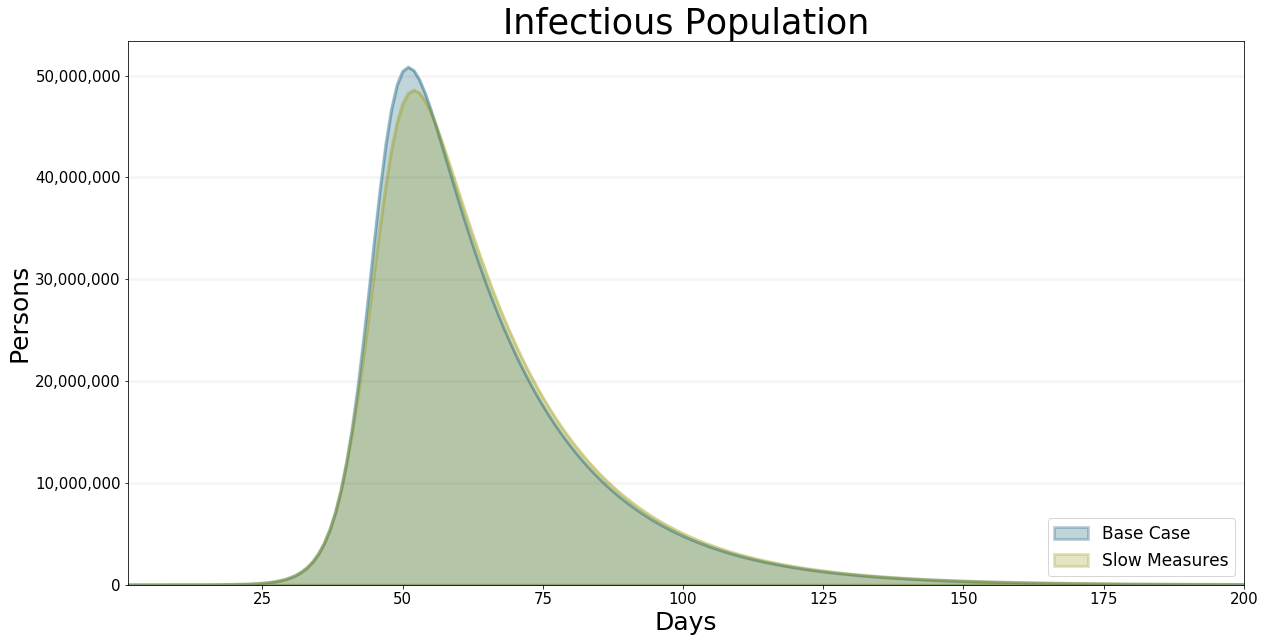

In [26]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactLargeGroups","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["I"],
    series_names={
        "smSir_model_base_I" : "Base Case",
        "smSir_model_contactLargeGroups_I" : "Slow Measures"
    },
    visualize_to_period=200
    
)

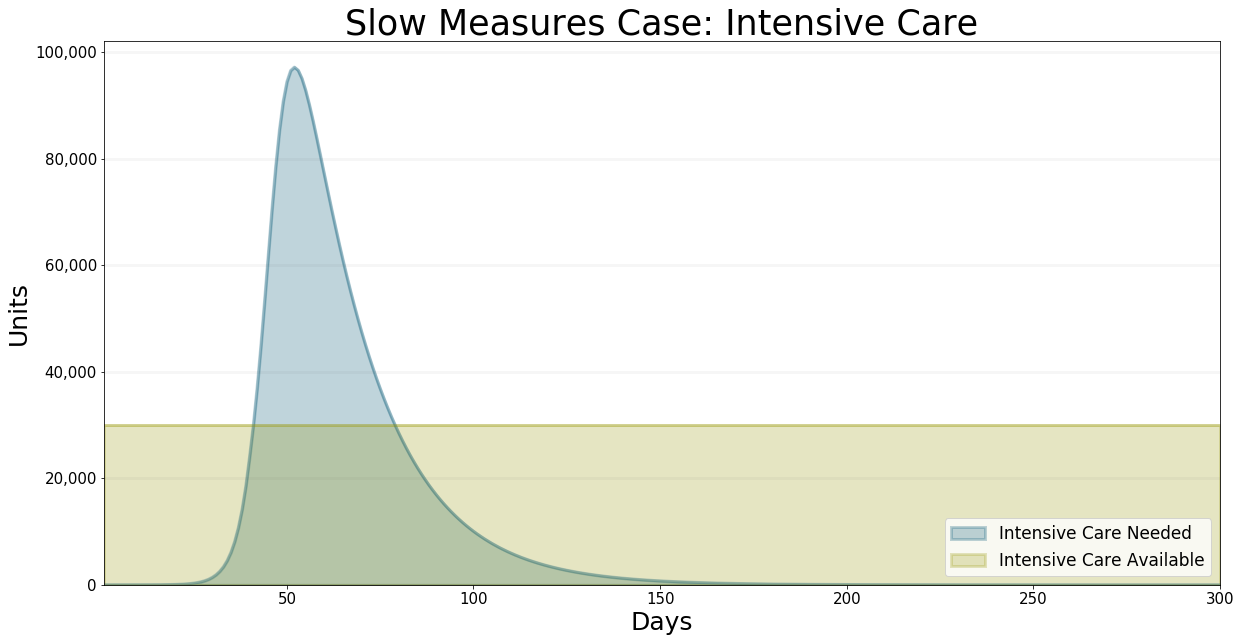

In [27]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactLargeGroups"],
    title="Slow Measures Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_model_contactLargeGroups_needed" : "Intensive Care Needed",
        "smSir_model_contactLargeGroups_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

### Reducing the contact rate from large groups to small groups

In [29]:
model_small_groups = bptk.scenario_manager_factory.scenario_managers['smSir_model'].scenarios['contactSmallGroups'].model
stoptime_small_groups = model_small_groups.stoptime

points_list_small = []
contact_small = contact_rate
for t in range(int(stoptime_small_groups)):
    if t==25:
        contact_small= 10
    if t==41:
        contact_small = 5
    if t==500:
        contact_small = 10
    if t==1200:
        contact_small = 20
    points_list_small.append((t,contact_small))


model_small_groups.points["contactPointsSmall"] = points_list_small
model_small_groups.equations["c"] = lambda t: LERP(t,model_small_groups.points["contactPointsSmall"])

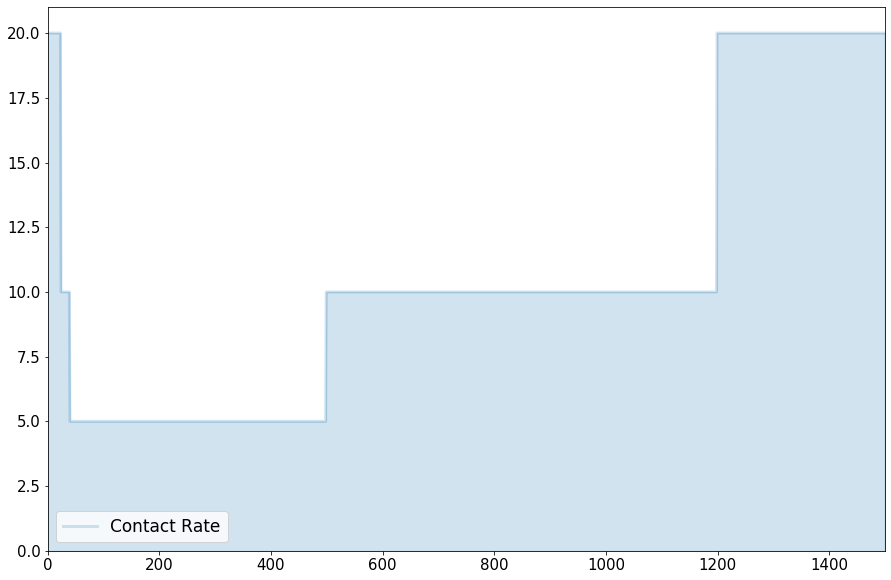

In [30]:
ax = pd.DataFrame([model_small_groups.equations["c"](t) for t in range(int(model_small_groups.starttime),int(model_small_groups.stoptime+1))]).plot(kind="area",alpha=0.2,figsize=(15,10))
ax.legend(["Contact Rate"])

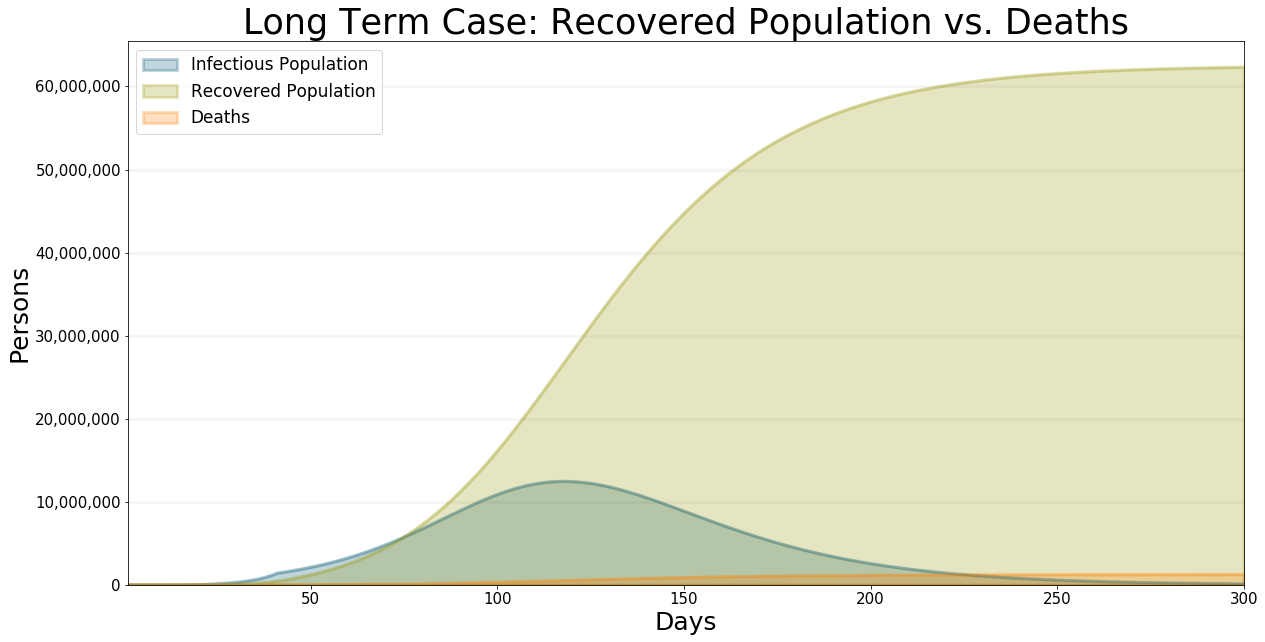

In [31]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactSmallGroups"],
    title="Long Term Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_model_contactSmallGroups_I" : "Infectious Population",
        "smSir_model_contactSmallGroups_R" : "Recovered Population",
        "smSir_model_contactSmallGroups_D": "Deaths"
    },
    visualize_to_period=300
)

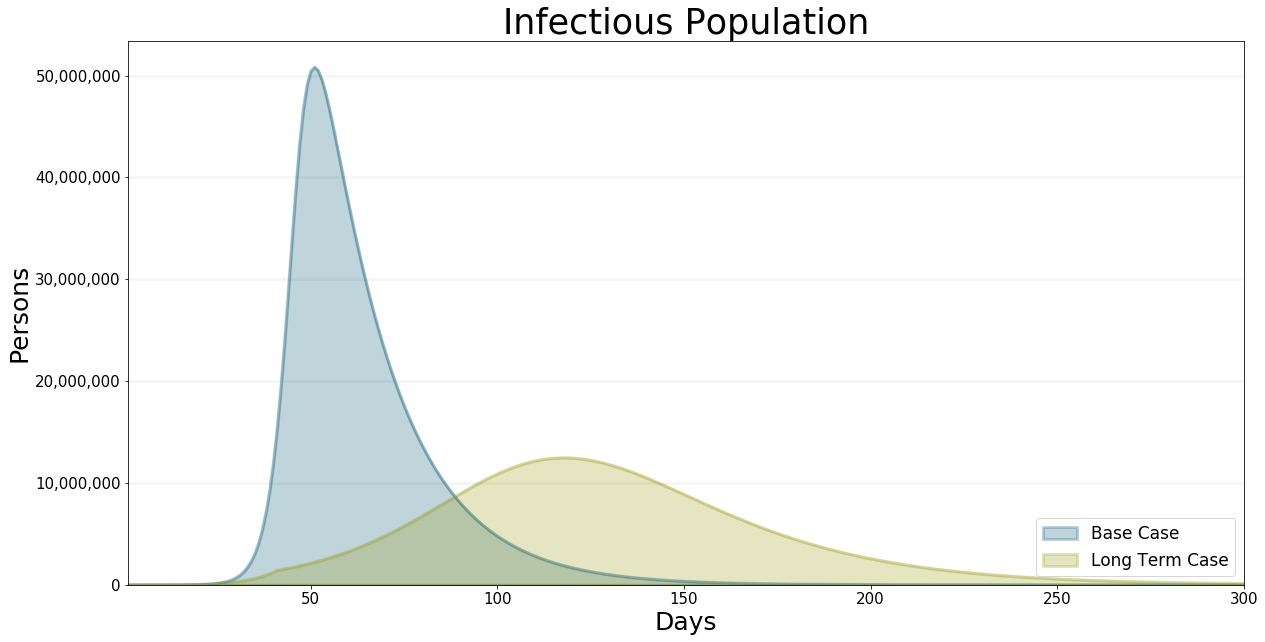

In [32]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactSmallGroups","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["I"],
    series_names={
        "smSir_model_base_I" : "Base Case",
        "smSir_model_contactSmallGroups_I" : "Long Term Case"
    },
    visualize_to_period=300
    
)

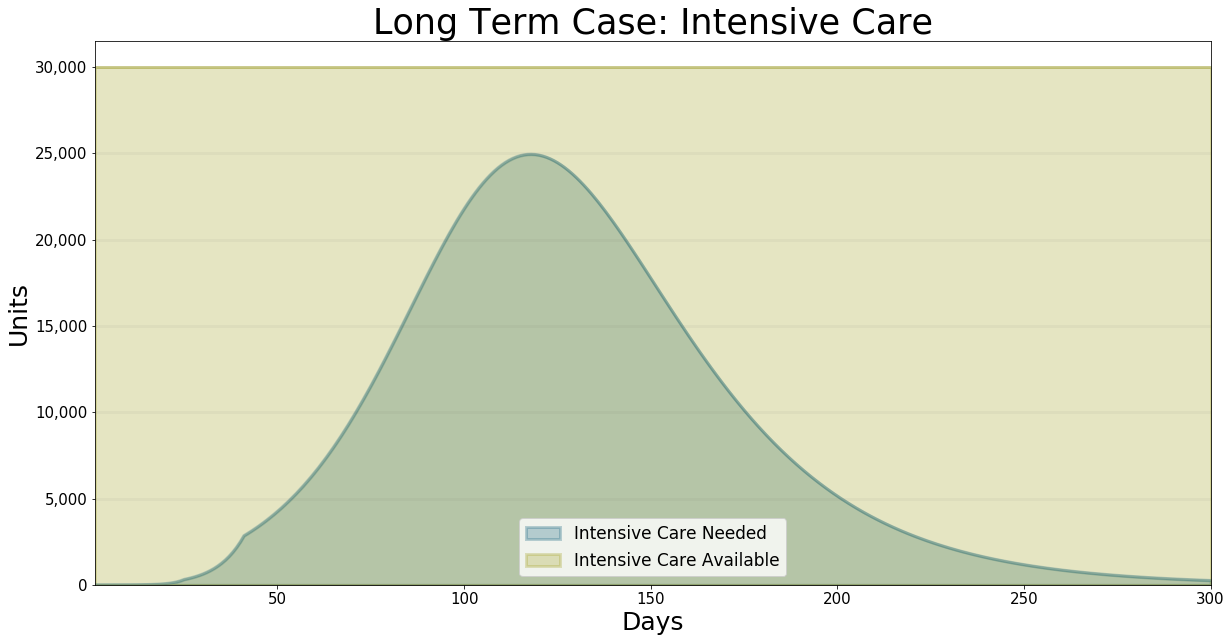

In [33]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactSmallGroups"],
    title="Long Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_model_contactSmallGroups_needed" : "Intensive Care Needed",
        "smSir_model_contactSmallGroups_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

### Reducing contact rate from large groups to two people for only a short period of time

In [35]:
model_two_people = bptk.scenario_manager_factory.scenario_managers['smSir_model'].scenarios['contactTwoPeople'].model
stoptime_two_people = model_two_people.stoptime

points_list_two = []
contact_two = contact_rate
for t in range(int(stoptime_two_people)):
    if t==10:
        contact_two = 2
    if t==100:
        contact_two = 20
    points_list_two.append((t,contact_two))


model_two_people.points["contactPointsTwo"] = points_list_two
model_two_people.equations["c"] = lambda t: LERP(t,model_two_people.points["contactPointsTwo"])

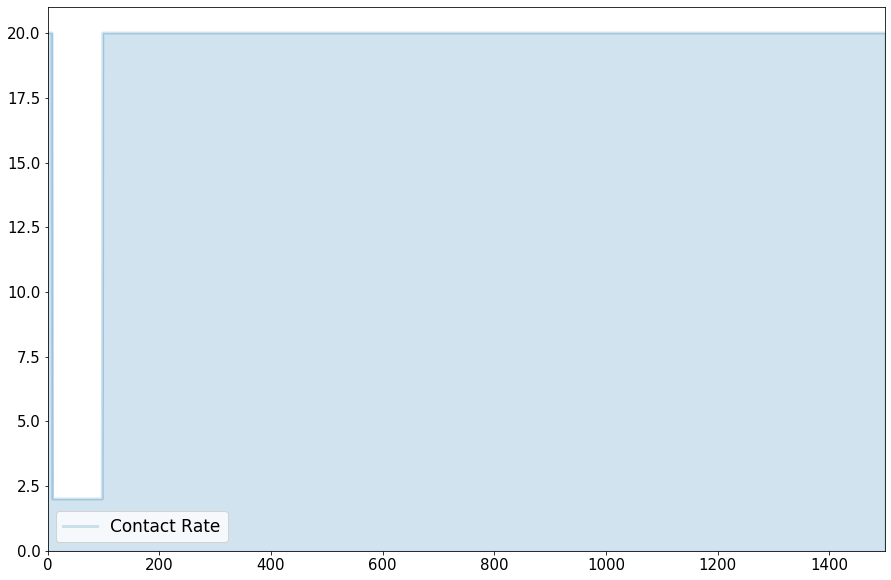

In [36]:
ax = pd.DataFrame([model_two_people.equations["c"](t) for t in range(int(model_two_people.starttime),int(model_two_people.stoptime+1))]).plot(kind="area",alpha=0.2,figsize=(15,10))
ax.legend(["Contact Rate"])

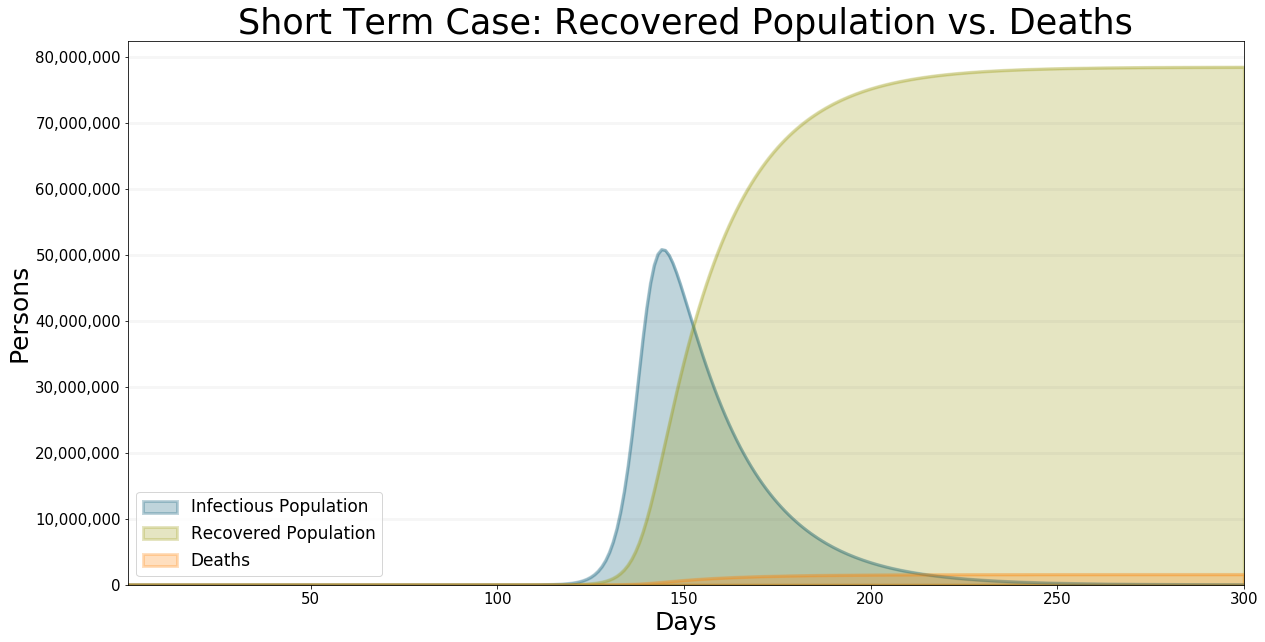

In [37]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactTwoPeople"],
    title="Short Term Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_model_contactTwoPeople_I" : "Infectious Population",
        "smSir_model_contactTwoPeople_R" : "Recovered Population",
        "smSir_model_contactTwoPeople_D": "Deaths"
    },
    visualize_to_period=300
)

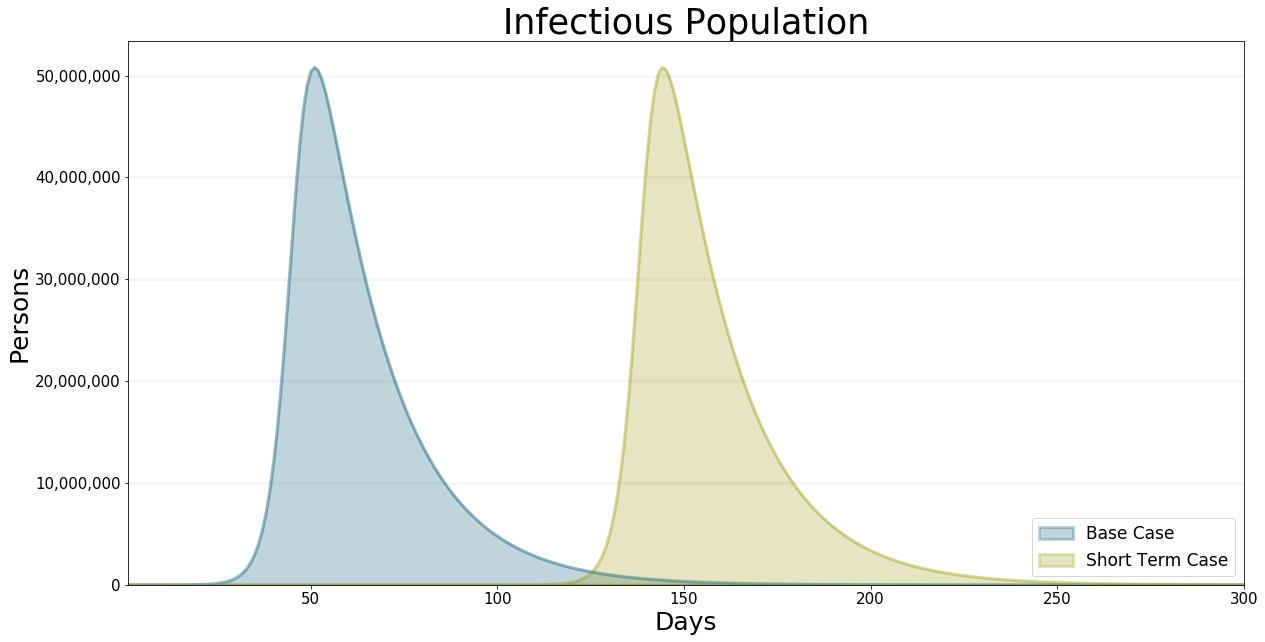

In [38]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactTwoPeople","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["I"],
    series_names={
        "smSir_model_base_I" : "Base Case",
        "smSir_model_contactTwoPeople_I" : "Short Term Case"
    },
    visualize_to_period=300
    
)

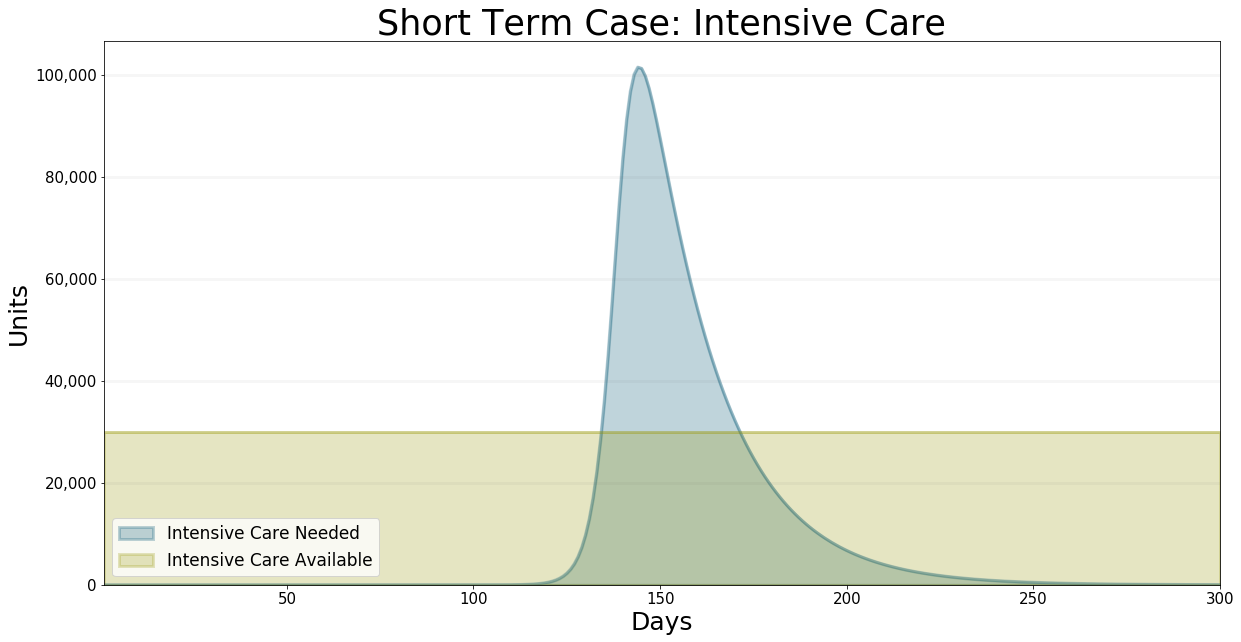

In [39]:
bptk.plot_scenarios(
    scenario_managers=["smSir_model"],
    scenarios=["contactTwoPeople"],
    title="Short Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_model_contactTwoPeople_needed" : "Intensive Care Needed",
        "smSir_model_contactTwoPeople_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)